In [1]:
import numpy as np
import scipy.stats
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

chr_list = abf.getChrList()

In [2]:
# The stitched enhancer gff for the merged H3K27ac peaks returned by ROSE
full_enhancer_gff = open('../super_enhancers/Leio_H3K27ac_MACS2_enhancers_ROSE_12KB_STITCHED.gff', 'r')

enhancer_dic = {}
for line in full_enhancer_gff:
    l = line.strip().split('\t')
    enhancer_dic[l[1]] = 0
    
full_enhancer_gff.close()

In [3]:
# Get the super enhancer calls for each patient to define super enhancers
for filename in os.listdir('../super_enhancers/pt_super_enhancer_calls/'):
    print(filename)
    file=open('../super_enhancers/pt_super_enhancer_calls/' + filename, 'r')
    for line in file:
        if(line[0] == '#'):
            continue
        l = line.strip().split('\t')
        if(l[0] in enhancer_dic):            
            if(int(l[-1]) == 1):
                enhancer_dic[l[0]] += 1

L_pt20_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt10_1_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt21_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt13_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt15_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt19_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt6_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt12_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt14_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt18_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt7_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt1_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt16_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt9_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt5_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt3_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L_pt11_H3K27ac_MACS2_enhancers_ROSE_AllEnhancers.table.txt
L

In [4]:
# How many super enhancers (called in at least one patient)
N = 0
for enhancer in enhancer_dic:
    if(enhancer_dic[enhancer] > 0):
        N += 1
print(N)

2275


In [5]:
# Get the altered genomic bins (make sure these are sorted by first coordinate)
pos_loc4_bed = abf.readBed('../region_files/leiomyoma_HOSVD_final_pos_loc4.txt')
neg_loc4_bed = abf.readBed('../region_files/leiomyoma_HOSVD_final_neg_loc4.txt')

In [6]:
# Read in information about the enhancer locations and sizes.
# The stitched enhancer file is obtained from calling the ROSE
# algorithm with the merged leiomyoma H3K27ac peaks.
full_enhancer_gff = open('../super_enhancers/Leio_H3K27ac_MACS2_enhancers_ROSE_12KB_STITCHED.gff', 'r')
enhancer_coord = []
for c, chrom in enumerate(chr_list):
    enhancer_coord.append([])
for line in full_enhancer_gff:
    l = line.strip().split('\t')
    is_SE = enhancer_dic[l[8]]
    enhancer_coord[chr_list[l[0]]].append([l[0], int(0.5*(int(l[3])+int(l[4]))), int(l[4]) - int(l[3]), l[8], is_SE])
full_enhancer_gff.close()

In [7]:
def shuffle_enhancers(enhancer_coord):
    '''Shuffle the enhancer locations.
    
    Rather than usual bed coordinates, the enhancers are
    specified by the location of the center and the width.
    Given such an array of enhancers, this function will 
    permute the location of all enhacners along the respective
    chromosome, holding all other fields fixed.
    '''
    enhancer_shuffle = [[] for c in range(len(chr_list))]
    for c in range(len(chr_list)):
        enhancer_shuffle[c] = [list(enhancer_coord[c][i]) for i in range(len(enhancer_coord[c]))]
        shuffle_i = np.random.choice(len(enhancer_coord[c]), len(enhancer_coord[c]), replace=False)
        for i in range(len(enhancer_coord[c])):
            enhancer_shuffle[c][i][1] = enhancer_coord[c][shuffle_i[i]][1]
    return enhancer_shuffle

def regions_overlap_enhancers(regions, enhancers):
    '''Get the number of regions overlapping super and typical enhancers.
    
    Given a typical bed array of regions, and a set of enhancers
    specified by center coordinate and width, find the number of 
    regions overlapping super enhancers and typical enhancers.
    Note this function assumes the regions are sorted by first 
    coordinate (the enhancers do not need to be sorted).
    '''
    n_SE, n_NE = 0, 0
    for c, chrom in enumerate(chr_list):
        for enh in enhancers[c]:
            start = enh[1] - int(0.5*enh[2])
            end = enh[1] + int(0.5*enh[2])
            for reg in regions[c]:
                if(reg[1] >= end):
                    break
                if(reg[2] <= start):
                    continue
                if(enh[-1] > 0):
                    n_SE += 1
                else:
                    n_NE += 1
    return n_SE, n_NE

def enhancers_overlap_regions(regions, enhancers):
    '''Get the number of super and normal enhancers overlapping a region.
    
    Given a typical bed array of regions, and a set of enhancers
    specified by center coordinate and width, find the number of
    super and normal enhancers that overlap one of the regions.
    Note this function assumes the regions are sorted by first 
    coordinate (the enhancers do not need to be sorted).
    '''
    n_SE, n_NE = 0, 0
    for c, chrom in enumerate(chr_list):
        for enh in enhancers[c]:
            start = enh[1] - int(0.5*enh[2])
            end = enh[1] + int(0.5*enh[2])
            for reg in regions[c]:
                if(reg[1] >= end):
                    break
                if(reg[2] <= start):
                    continue
                if(enh[-1] > 0):
                    n_SE += 1
                else:
                    n_NE += 1
                break
    return n_SE, n_NE

In [8]:
N_SE, N_NE = regions_overlap_enhancers(pos_loc4_bed, enhancer_coord)
print("Genomic bins with lower histone modifications in leiomyoma")
print("Number overlapping a super enhancer: ", N_SE)
print("Number overlapping a typical enhancer: ", N_NE)

Genomic bins with lower histone modifications in leiomyoma
Number overlapping a super enhancer:  617
Number overlapping a typical enhancer:  656


In [9]:
N_SE, N_NE = regions_overlap_enhancers(neg_loc4_bed, enhancer_coord)
print("Genomic bins with higher histone modifications in leiomyoma")
print("Number overlapping a super enhancer: ", N_SE)
print("Number overlapping a typical enhancer: ", N_NE)

Genomic bins with higher histone modifications in leiomyoma
Number overlapping a super enhancer:  1345
Number overlapping a typical enhancer:  469


In [10]:
N_SE, N_NE = enhancers_overlap_regions(pos_loc4_bed, enhancer_coord)
print("Enhancers overlapping a genomic bin with lower histone modifications in leiomyoma")
print("Number of altered super enhancers: ", N_SE)
print("Number of altered typical enhancers: ", N_NE)

Enhancers overlapping a genomic bin with lower histone modifications in leiomyoma
Number of altered super enhancers:  245
Number of altered typical enhancers:  462


In [11]:
# The number of each class of enhancer that overlap a 
# genomic bin with higher histone modifications in leiomyoma
N_SE, N_NE = enhancers_overlap_regions(neg_loc4_bed, enhancer_coord)
print("Enhancers overlapping a genomic bin with higher histone modifications in leiomyoma")
print("Number of altered super enhancers: ", N_SE)
print("Number of altered typical enhancers: ", N_NE)      

Enhancers overlapping a genomic bin with higher histone modifications in leiomyoma
Number of altered super enhancers:  466
Number of altered typical enhancers:  385


In [12]:
## Permutation tests ##

# Permute the centers of the enhancers on each chromosome and recompute
# each of the overlaps described above for the true regions. Do 1000 iterations
# for each and compare these to the true values.

In [13]:
n_iter = 1000
sampled_pos_overlap = []
for it in range(n_iter):
    sampled_pos_overlap.append(regions_overlap_enhancers(pos_loc4_bed, shuffle_enhancers(enhancer_coord)))

In [14]:
n_iter = 1000
sampled_neg_overlap = []
for it in range(n_iter):
    sampled_neg_overlap.append(regions_overlap_enhancers(neg_loc4_bed, shuffle_enhancers(enhancer_coord)))

In [15]:
n_iter = 1000
enhancer_pos_overlap = []
for it in range(n_iter):
    enhancer_pos_overlap.append(enhancers_overlap_regions(pos_loc4_bed, shuffle_enhancers(enhancer_coord)))

In [16]:
n_iter = 1000
enhancer_neg_overlap = []
for it in range(n_iter):
    enhancer_neg_overlap.append(enhancers_overlap_regions(neg_loc4_bed, shuffle_enhancers(enhancer_coord)))

Text(0.5, 1.0, 'Overlap of bins lower in leiomyoma\nwith super enhancers')

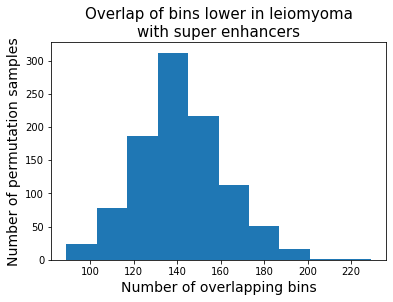

In [17]:
h = plt.hist([sampled_pos_overlap[i][0] for i in range(n_iter)])
plt.xlabel('Number of overlapping bins', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Overlap of bins lower in leiomyoma\nwith super enhancers', fontsize=15)

Text(0.5, 1.0, 'Overlap of bins lower in leiomyoma\nwith normal enhancers')

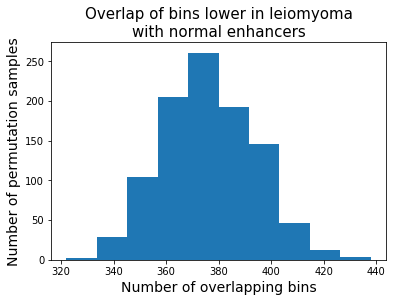

In [18]:
h = plt.hist([sampled_pos_overlap[i][1] for i in range(n_iter)])
plt.xlabel('Number of overlapping bins', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Overlap of bins lower in leiomyoma\nwith normal enhancers', fontsize=15)

Text(0.5, 1.0, 'Overlap of bins higher in leiomyoma\nwith super enhancers')

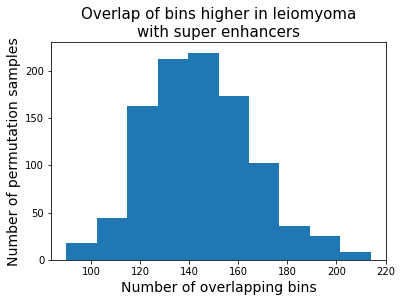

In [19]:
h = plt.hist([sampled_neg_overlap[i][0] for i in range(n_iter)])
plt.xlabel('Number of overlapping bins', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Overlap of bins higher in leiomyoma\nwith super enhancers', fontsize=15)

Text(0.5, 1.0, 'Overlap of bins higher in leiomyoma\nwith normal enhancers')

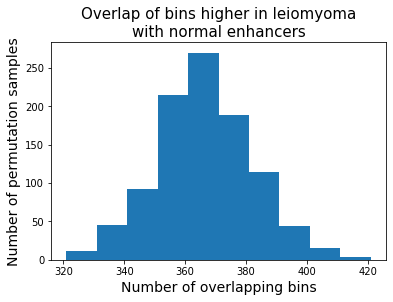

In [20]:
h = plt.hist([sampled_neg_overlap[i][1] for i in range(n_iter)])
plt.xlabel('Number of overlapping bins', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Overlap of bins higher in leiomyoma\nwith normal enhancers', fontsize=15)

Text(0.5, 1.0, 'Super enhancers overlapping altered\nregions lower in leiomyoma')

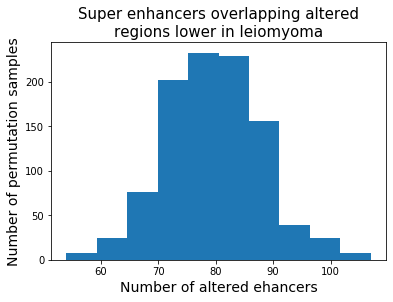

In [21]:
h = plt.hist([enhancer_pos_overlap[i][0] for i in range(n_iter)])
plt.xlabel('Number of altered ehancers', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Super enhancers overlapping altered\nregions lower in leiomyoma', fontsize=15)

Text(0.5, 1.0, 'Normal enhancers overlapping altered\nregions lower in leiomyoma')

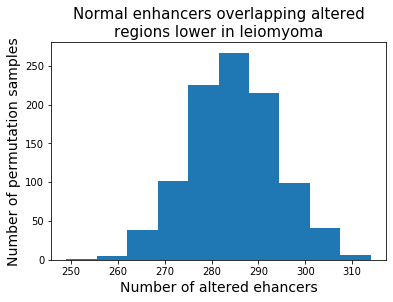

In [22]:
h = plt.hist([enhancer_pos_overlap[i][1] for i in range(n_iter)])
plt.xlabel('Number of altered ehancers', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Normal enhancers overlapping altered\nregions lower in leiomyoma', fontsize=15)

Text(0.5, 1.0, 'Super enhancers overlapping altered\nregions higher in leiomyoma')

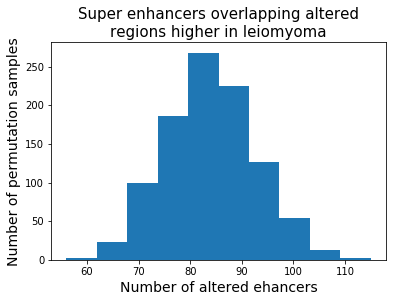

In [23]:
h = plt.hist([enhancer_neg_overlap[i][0] for i in range(n_iter)])
plt.xlabel('Number of altered ehancers', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Super enhancers overlapping altered\nregions higher in leiomyoma', fontsize=15)

Text(0.5, 1.0, 'Normal enhancers overlapping altered\nregions higher in leiomyoma')

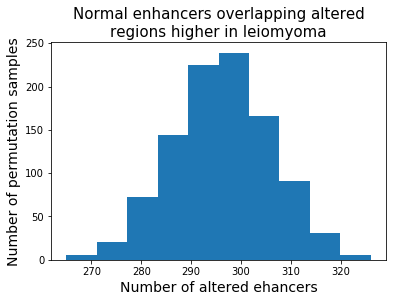

In [24]:
h = plt.hist([enhancer_neg_overlap[i][1] for i in range(n_iter)])
plt.xlabel('Number of altered ehancers', fontsize=14)
plt.ylabel('Number of permutation samples', fontsize=14)
plt.title('Normal enhancers overlapping altered\nregions higher in leiomyoma', fontsize=15)